In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from pytorch_model_summary import summary
import pkbar


import matplotlib.pyplot as plt
import numpy as np

from torch.utils.tensorboard import SummaryWriter
import time

In [2]:
batch_size = 512

workers = 20

num_epochs = 10

learning_rate = 0.001

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [24]:
trainDataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testDataset = datasets.MNIST('./data', train=False, transform=transform)

trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, num_workers=workers, pin_memory=True, shuffle=True)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, num_workers=workers, pin_memory=True, shuffle=True)

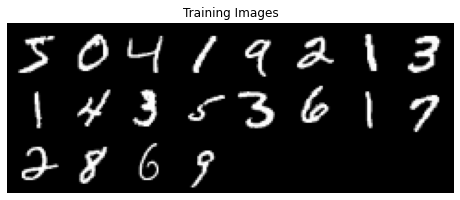

In [5]:
real_batch = next(iter(trainDataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:24], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3(x))
        
        return x

In [7]:
print(summary(Encoder(), torch.zeros((1, 1, 28, 28)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 28, 28]             544             544
          Conv2d-2     [1, 32, 29, 29]          16,416          16,416
          Conv2d-3     [1, 32, 14, 14]          32,832          32,832
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
-----------------------------------------------------------------------


In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convT1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.convT3 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=1, padding=2)
        
    def forward(self, x):
        x = F.relu(self.convT1(x))
        
        x = F.relu(self.convT2(x))
        
        x = F.sigmoid(self.convT3(x))
        
        return x

In [9]:
print(summary(Decoder(), torch.zeros((1, 64, 7, 7)), show_input=True))

-------------------------------------------------------------------------
        Layer (type)         Input Shape         Param #     Tr. Param #
   ConvTranspose2d-1       [1, 64, 7, 7]          32,800          32,800
   ConvTranspose2d-2     [1, 32, 14, 14]           8,208           8,208
   ConvTranspose2d-3     [1, 16, 29, 29]             257             257
Total params: 41,265
Trainable params: 41,265
Non-trainable params: 0
-------------------------------------------------------------------------


/home/ashim/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [10]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.latent_dim = latent_dim
        
        self.mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        self.upsample = nn.Linear(latent_dim, 64 * 7 * 7)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def forward(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        
        latent_mu = self.mu(x)
        latent_logvar = self.logvar(x)
        latent_sample = self.reparameterize(mu=latent_mu, logvar=latent_logvar)
        upsampled = self.upsample(latent_sample).view(-1, 64, 7, 7)
        
        x_recon = self.decoder(upsampled)
        
        return x_recon, latent_mu, latent_logvar

In [11]:
print(summary(VariationalAutoEncoder(encoder=Encoder(), decoder=Decoder(), latent_dim=100), torch.zeros((1, 1, 28, 28)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Encoder-1      [1, 1, 28, 28]          49,792          49,792
          Linear-2           [1, 3136]         313,700         313,700
          Linear-3           [1, 3136]         313,700         313,700
          Linear-4            [1, 100]         316,736         316,736
         Decoder-5       [1, 64, 7, 7]          41,265          41,265
Total params: 1,035,193
Trainable params: 1,035,193
Non-trainable params: 0
-----------------------------------------------------------------------


In [12]:
encoder = Encoder()
decoder = Decoder()
vae = VariationalAutoEncoder(encoder, decoder, latent_dim=100).to(device)

In [13]:
def vae_loss(recon_x, x , mu, logvar):
        
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
    total_loss = recon_loss + kldivergence
    return total_loss , recon_loss, kldivergence

In [14]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [15]:
execution_time = time.ctime()
writer = SummaryWriter('./model_data/' + '/logs/' + execution_time)

In [16]:
#torch.autograd.set_detect_anomaly(True)

In [17]:
%%time

print("Started Training Loop........")

batch_per_train_epoch = len(trainDataloader)

iters = 0
for epoch in range(num_epochs):
    num_batch = 0 
    
    vae.train()
    
    print('Epoch: {}'.format(epoch+1))
    kbar = pkbar.Kbar(target=batch_per_train_epoch, width=8)
    
    for img_batch,_ in trainDataloader:
        
        img_batch = img_batch.to(device)
        
        vae.zero_grad()
        
        img_batch_recon, latent_mu, latent_logvar = vae(img_batch)
                
        error, recon_loss, kldivergence = vae_loss(img_batch_recon, img_batch, latent_mu, latent_logvar)
        
        error.backward()
        optimizer.step()

        
        kbar.update(num_batch, values=[("total_loss", error.detach()), ("recon_loss", recon_loss.detach()), ("kldivergence_loss", kldivergence.detach())])
        writer.add_scalar("total_loss/train", error.detach(), iters)
        writer.add_scalar("recon_loss/train", recon_loss.detach(), iters)
        writer.add_scalar("kldivergence_loss/train", kldivergence.detach(), iters)

        iters += 1
        num_batch += 1
    
    vae.eval()
    with torch.no_grad():
        val_img_batch, _ = next(iter(testDataloader))
        val_img_batch = val_img_batch.to(device)
                
        val_img_batch_recon, val_latent_mu, val_latent_logvar = vae(val_img_batch)
        
        val_error, val_recon_loss, val_kldivergence =  vae_loss(val_img_batch_recon, val_img_batch, val_latent_mu, val_latent_logvar)
       
        writer.add_scalar("total_loss/validation", val_error.detach(), epoch + 1)
        writer.add_scalar("recon_loss/validation", val_recon_loss.detach(), epoch + 1)
        writer.add_scalar("kldivergence_loss/validation", val_kldivergence.detach(), epoch + 1)

    
    kbar.add(1, values= [ ("total_loss", error.detach()), ("recon_loss", recon_loss.detach()), ("kldivergence_loss", kldivergence.detach()), ("val_total_loss", val_error.detach()), ("val_recon_loss", val_recon_loss.detach()), ("val_kldivergence_loss", val_kldivergence.detach())  ])

Started Training Loop........
Epoch: 1
118/118 [========] - 12s 102ms/step - total_loss: 118126.8265 - recon_loss: 113924.7998 - kldivergence_loss: 4202.0266 - val_total_loss: 86366.5156 - val_recon_loss: 80717.3906 - val_kldivergence_loss: 5649.1240
Epoch: 2
118/118 [========] - 11s 97ms/step - total_loss: 80719.3901 - recon_loss: 70391.5865 - kldivergence_loss: 10327.8035 - val_total_loss: 62181.3867 - val_recon_loss: 50204.7656 - val_kldivergence_loss: 11976.6221
Epoch: 3
118/118 [========] - 12s 99ms/step - total_loss: 65003.8846 - recon_loss: 51415.2619 - kldivergence_loss: 13588.6229 - val_total_loss: 54576.4219 - val_recon_loss: 40214.9453 - val_kldivergence_loss: 14361.4785
Epoch: 4
118/118 [========] - 12s 100ms/step - total_loss: 58938.3361 - recon_loss: 44775.0972 - kldivergence_loss: 14163.2388 - val_total_loss: 50811.2227 - val_recon_loss: 36321.2070 - val_kldivergence_loss: 14490.0156
Epoch: 5
118/118 [========] - 12s 101ms/step - total_loss: 56679.0411 - recon_loss: 4237

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils


Original images


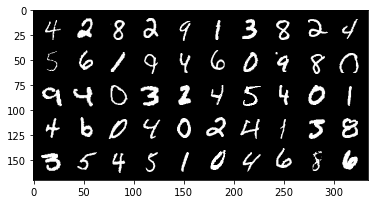

VAE reconstruction:


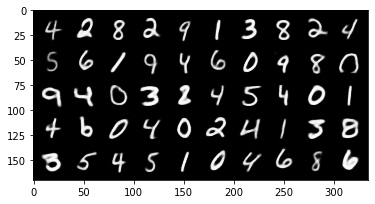

In [27]:
vae.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[0:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(testDataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[0:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)